In [153]:
# a bunch of scratch work used to generate tables, hand tuning and combine results
import os 
import sys 
import time 
import numpy as np
import json
import tpch_param as tp 

In [154]:
# hand tuning = pick the lowest time for each param after one deterministic run
fnames = ['sf10_n10_det_main0.txt', 'sf10_n10_det_main_fix.txt']#
#['sf1_n10_det_main2.txt', 'sf1_n10_det_main.txt']
direc = './training_results'
training_fnames = [f'{direc}/{x}'for x in os.listdir(direc) if x in fnames]
param_val = {} #fname -> param_val -> list of times
names = []
params = []
for FNAME in training_fnames:
    print(FNAME)
    param_val[FNAME] = {}
    with open(FNAME, "r") as file:
        for line in file:
            d = eval(line)

            params = [p for p in d["params"] if p['spark_param']]
            names = [p['name'] for p in d["params"] if p['spark_param']]
            runtimes = d["runtimes"]
            if len(runtimes) == 0:
                continue

            all_default = True
            varying_param = 'default'
            varying_val = ''
            for p in params:
                if str(p['cur_value']) != str(p['default_value']):
                    varying_param = p['name']
                    varying_val = p['cur_value']
                    all_default = False
                    break
            param_val[FNAME].setdefault(f'{varying_param}_{varying_val}',[]).append(runtimes)

./training_results/sf10_n10_det_main0.txt
./training_results/sf10_n10_det_main_fix.txt


In [155]:
pvals = {} # fname -> param -> best val
for FNAME in param_val:
    print(FNAME)
    pvals[FNAME] = {}
    afname = "AVG_"+FNAME
    pvals[afname] = {}
    for pname in sorted(names):
        
        defa = [p['default_value'] for p in params if p['name'] == pname][0]
        print(pname, ": --- ", defa)
        vals = [(np.median([x['total'] for x in rt]), pv) for pv, rt in param_val[FNAME].items() if pname in pv or pv == 'default_']
        vals = sorted(vals)
        if vals[0][1] == 'default_':
            pvals[FNAME][pname] = defa
        else:
            pvals[FNAME][pname] = vals[0][1].split("_")[1] 
        
        avg_vals = [(np.average([x['total'] for x in rt]), pv) for pv, rt in param_val[FNAME].items() if pname in pv or pv == 'default_']
        avg_vals = sorted(avg_vals)
        if avg_vals[0][1] == 'default_':
            pvals[afname][pname] = defa
        else:
            pvals[afname][pname] = avg_vals[0][1].split("_")[1] 
            
        for i, v in enumerate(vals):
            print(f'{v[1]}: {round(v[0], 3)} sec,  AVG {avg_vals[i][1].split("_")[1]}: {round(avg_vals[i][0], 3)} sec, {len(param_val[FNAME][v[1]] if "default" not in v[1] else param_val[FNAME]["default_"])}')
        print("---")


./training_results/sf10_n10_det_main0.txt
spark.broadcast.blockSize : ---  4m
default_: 182.216 sec,  AVG 24m: 213.242 sec, 9
spark.broadcast.blockSize_6m: 184.116 sec,  AVG 6m: 214.705 sec, 9
spark.broadcast.blockSize_8m: 184.428 sec,  AVG : 215.921 sec, 9
spark.broadcast.blockSize_16m: 184.464 sec,  AVG 16m: 216.553 sec, 9
spark.broadcast.blockSize_14m: 184.79 sec,  AVG 14m: 216.934 sec, 9
spark.broadcast.blockSize_10m: 184.871 sec,  AVG 8m: 216.962 sec, 9
spark.broadcast.blockSize_22m: 185.127 sec,  AVG 22m: 217.128 sec, 9
spark.broadcast.blockSize_12m: 185.47 sec,  AVG 12m: 218.91 sec, 9
spark.broadcast.blockSize_18m: 185.926 sec,  AVG 10m: 221.129 sec, 9
spark.broadcast.blockSize_24m: 187.145 sec,  AVG 20m: 229.21 sec, 9
spark.broadcast.blockSize_20m: 189.301 sec,  AVG 18m: 255.763 sec, 9
---
spark.broadcast.compress : ---  true
default_: 182.216 sec,  AVG : 215.921 sec, 9
spark.broadcast.compress_false: 184.453 sec,  AVG false: 217.446 sec, 9
---
spark.default.parallelism : ---  

In [156]:
# somewhat good result? -- handtuning sometimes selected the same parameters across both

#training_fnames
#pvals[FNAME][pname] = defa
print(training_fnames)
for pname in sorted(names):
    print(f"'{pname}': Median best val (job1) (job2)", pvals[training_fnames[0]][pname], pvals[training_fnames[1]][pname], "AVG best val", pvals["AVG_"+training_fnames[0]][pname], pvals["AVG_"+training_fnames[1]][pname])

['./training_results/sf10_n10_det_main0.txt', './training_results/sf10_n10_det_main_fix.txt']
'spark.broadcast.blockSize': Median best val (job1) (job2) 4m 12m AVG best val 24m 12m
'spark.broadcast.compress': Median best val (job1) (job2) true false AVG best val true false
'spark.default.parallelism': Median best val (job1) (job2) 140 60 AVG best val 60 60
'spark.driver.cores': Median best val (job1) (job2) 1 3 AVG best val 1 4
'spark.driver.memory': Median best val (job1) (job2) 3g 4g AVG best val 4g 4g
'spark.executor.cores': Median best val (job1) (job2) 6 5 AVG best val 6 5
'spark.executor.instances': Median best val (job1) (job2) 6 8 AVG best val 2 8
'spark.executor.memory': Median best val (job1) (job2) 5g 3g AVG best val 1g 7g
'spark.io.compression.codec': Median best val (job1) (job2) lz4 lz4 AVG best val snappy lz4
'spark.memory.fraction': Median best val (job1) (job2) 0.5 0.5 AVG best val 0.5 0.6
'spark.memory.storageFraction': Median best val (job1) (job2) 0.5 0.7 AVG best v

In [157]:
# handtuning result based on sf 10 results
hand_tuning10 = {
'spark.broadcast.blockSize':  '24m',
'spark.broadcast.compress':  'false',
'spark.default.parallelism':  '60',
'spark.driver.cores':  '3',
'spark.driver.memory':  '4g',
'spark.executor.cores':  '3',
'spark.executor.instances':  '8',
'spark.executor.memory':  '7g',
'spark.io.compression.codec':  'snappy',
'spark.memory.fraction':  '0.5',
'spark.memory.storageFraction':  '0.6',
'spark.rdd.compress':  'true', 
'spark.reducer.maxSizeInFlight':  '72m',
'spark.rpc.message.maxSize': '224',
'spark.shuffle.compress':  'false',
'spark.shuffle.file.buffer':  '32k',
'spark.shuffle.spill.compress':  'false', 
'spark.sql.shuffle.partitions':  '80',
'spark.task.cpus':  '1',  
}

In [158]:
# based on sf 1 results
hand_tuning = {
'spark.broadcast.blockSize':  '14m',
'spark.broadcast.compress':  'false',
'spark.default.parallelism':  '20',
'spark.driver.cores':  '3',
'spark.driver.memory':  '4g',
'spark.executor.cores':  '8',
'spark.executor.instances':  '8',
'spark.executor.memory':  '4g',
'spark.io.compression.codec':  'snappy',
'spark.memory.fraction':  '0.8',
'spark.memory.storageFraction':  '0.7',
'spark.rdd.compress':  'true', 
'spark.reducer.maxSizeInFlight':  '80m',
'spark.rpc.message.maxSize': '192',
'spark.shuffle.compress':  'false',
'spark.shuffle.file.buffer':  '48k',
'spark.shuffle.spill.compress':  'false', 
'spark.sql.shuffle.partitions':  '50',
'spark.task.cpus':  '1',  
}

In [159]:
# combine deterministic and random parameter runtimes into a single json file that can be input into the other models
fnames = ['sf10_n10_det_main0.txt', 'sf10_n10_det_main_fix.txt']#
#['sf1_n10_det_main2.txt', 'sf1_n10_det_main.txt']
direc = './training_results'
training_fnames = [f'{direc}/{x}'for x in os.listdir(direc) if x in fnames]
param_vals = {} #fname -> param_val -> list of times
names = []
params = []
for FNAME in training_fnames:
    print(FNAME)
    with open(FNAME, "r") as file:
        for line in file:
            d = eval(line)

            params = [p for p in d["params"] if p['spark_param']]
            names = [p['name'] for p in d["params"] if p['spark_param']]
            runtimes = d["runtimes"]
            
            varying_param = 'default'
            varying_val = ''
            for p in params:
                if str(p['cur_value']) != str(p['default_value']):
                    varying_param = p['name']
                    varying_val = p['cur_value']
                    break
                    
            if len(runtimes) == 0:
                param_vals.setdefault(f'{varying_param}_{varying_val}',[[],d])
                continue
                
            param_vals.setdefault(f'{varying_param}_{varying_val}',[[],d])[0].append(runtimes['total'])
           
count = 0
result = {}
valid = 0

for times, d in param_vals.values():
    if len(times) > 0:
        before = d['runtimes']['total']
        d['runtimes']['total'] = np.median(times) 
        valid += 1
        #print(before, d['runtimes']['total'])
    result[count] = d
    count += 1
print(count)
training_fnames = [f'{direc}/{x}'for x in os.listdir(direc) if 'txt' in x and 'sf10_n1_rand' in x]
for fname in training_fnames:
    with open(fname, "r") as training_data:
        for line in training_data:
            result[count] = eval(line)
            if result[count]['runtimes']:
                valid += 1
            count +=1

# Writing to sample.json
with open(f"{direc}/sf10_training_data.json", "w") as outfile:
    json.dump(result, outfile)
f = open(f"{direc}/sf10_training_data.txt", "r")
x = f.readlines()
print(len(x), sum(1 if eval(t)['runtimes'] else 0 for t in x))
print("count" , count, '# valid', valid)
f.close()

./training_results/sf10_n10_det_main0.txt
./training_results/sf10_n10_det_main_fix.txt
88
2882 2625
count 3145 # valid 2865


In [160]:
# find overall lowest runtime parameter set -- random search tuning
min_rt = float("inf")
best_p = {}
for d in result.values():
    if d['runtimes'] and d['runtimes']['total'] < min_rt:
        best_p = d['params']
        min_rt = d['runtimes']['total']
default_p = {p['name']: str(p['default_value']) for p in best_p if p['spark_param']}
best_p = {p['name']: p['cur_value'] for p in best_p if p['spark_param']}
#print(default_p)
print({k:v for k,v in sorted(best_p.items())})

{'spark.broadcast.blockSize': '6m', 'spark.broadcast.compress': 'false', 'spark.default.parallelism': 60, 'spark.driver.cores': 3, 'spark.driver.memory': '4g', 'spark.executor.cores': 3, 'spark.executor.instances': 7, 'spark.executor.memory': '1g', 'spark.io.compression.codec': 'snappy', 'spark.memory.fraction': 0.6, 'spark.memory.storageFraction': 0.4, 'spark.rdd.compress': 'true', 'spark.reducer.maxSizeInFlight': '64m', 'spark.rpc.message.maxSize': '192', 'spark.shuffle.compress': 'true', 'spark.shuffle.file.buffer': '96k', 'spark.shuffle.spill.compress': 'true', 'spark.sql.shuffle.partitions': 60, 'spark.task.cpus': 1}


In [161]:
# pretty print the parameter sets for the paper
from tpch_param import *
param_lists = get_param_lists()
raw_param_lists = [{p['name']:p['cur_value'] for p in pl} for pl in param_lists]
deft = raw_param_lists[0]
'''
for ps in raw_param_lists:
    print("----")
    print(str(tuple(v for  _, v in sorted(ps.items()))).replace("'",""))

print(str(tuple(sorted(ps))).replace("'",''))
'''

'\nfor ps in raw_param_lists:\n    print("----")\n    print(str(tuple(v for  _, v in sorted(ps.items()))).replace("\'",""))\n\nprint(str(tuple(sorted(ps))).replace("\'",\'\'))\n'

15
15 dict_values(['default', 'hand_tuning1', 'hand_tuning2', 'random_search', 'markov1', 'markov2', 'markov3', 'markov4', 'markov5', 'markov6', 'random_forest1', 'random_forest2', 'random_forest3', 'random_forest4', 'random_forest5'])
['./training_results/sf10_n10_compare_all_main7.txt', './training_results/sf10_n10_compare_all_main5.txt', './training_results/sf10_n10_compare_all_main4.txt', './training_results/sf10_n10_compare_all_main3.txt', './training_results/sf10_n10_compare_all_main2.txt', './training_results/sf10_n10_compare_all_main1.txt', './training_results/sf10_n10_compare_all_main8.txt']
('6m', 'false', '260', '3', '4g', '7', '5', '7g', 'snappy', '0.7', '0.6', 'false', '80m', '256', 'true', '32k', 'false', '80', '1') !!!
('6m', 'true', '180', '4', '4g', '1', '2', '4g', 'snappy', '0.4', '0.4', 'true', '80m', '256', 'false', '112k', 'false', '70', '1') !!!
('12m', 'false', '380', '1', '4g', '4', '6', '4g', 'snappy', '0.7', '0.7', 'false', '72m', '224', 'false', '80k', 'false

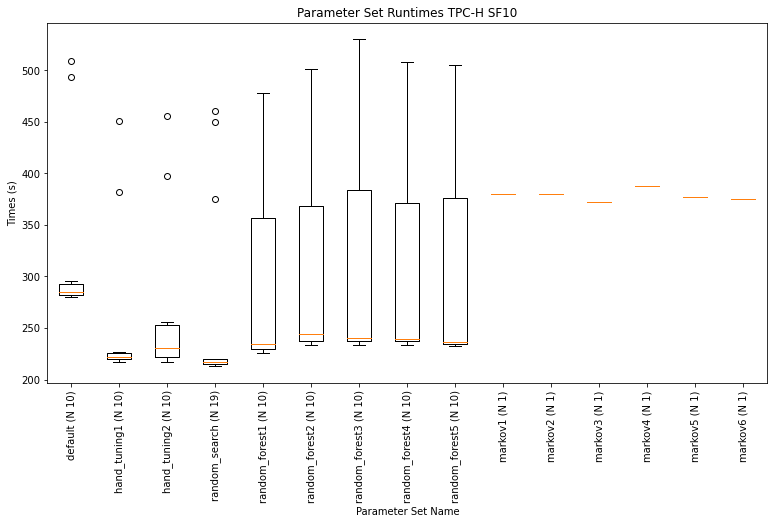

sf10_n10_compare_all_main5


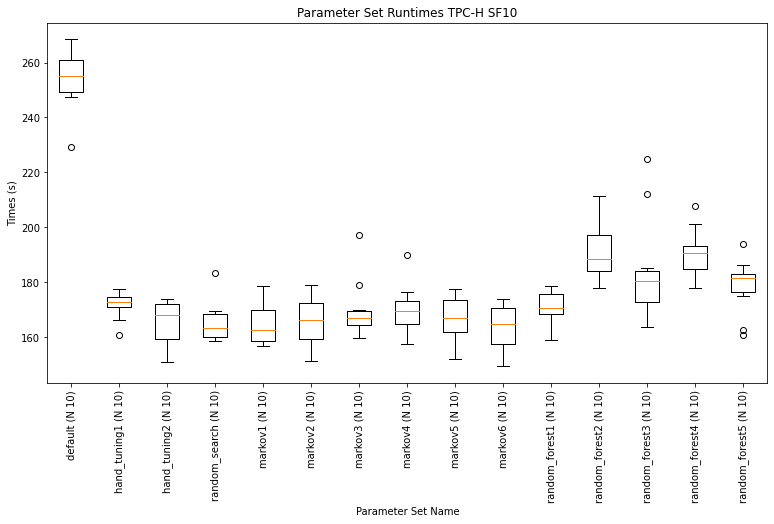

sf10_n10_compare_all_main4


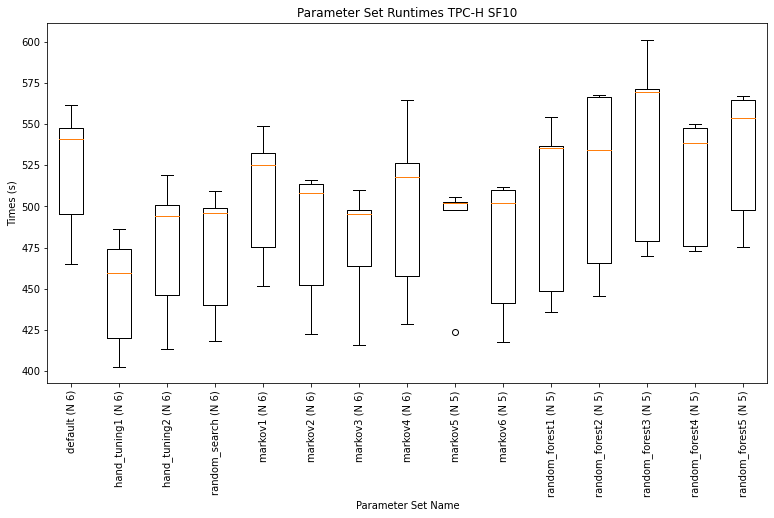

sf10_n10_compare_all_main3


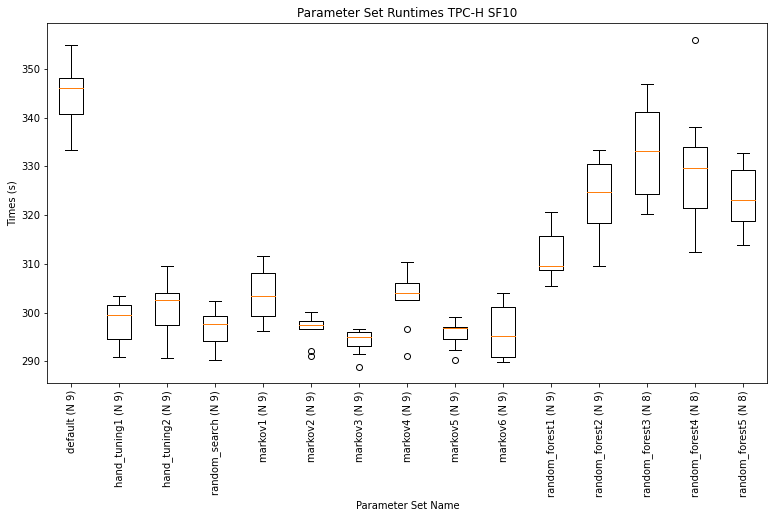

sf10_n10_compare_all_main2


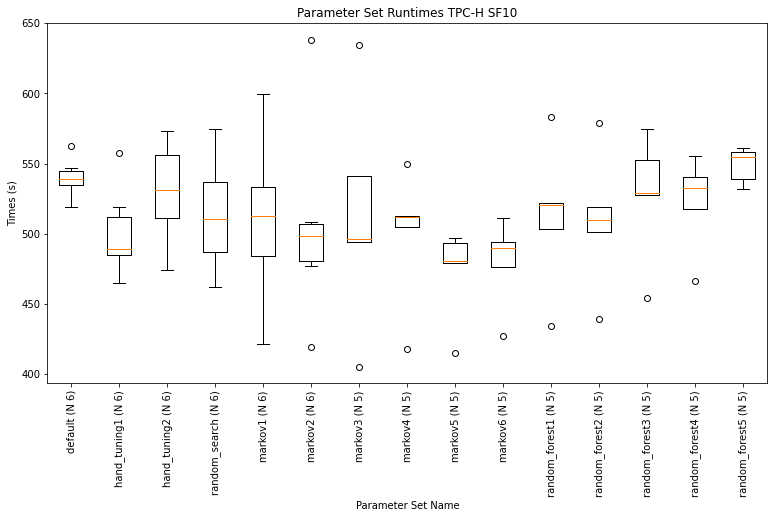

sf10_n10_compare_all_main1


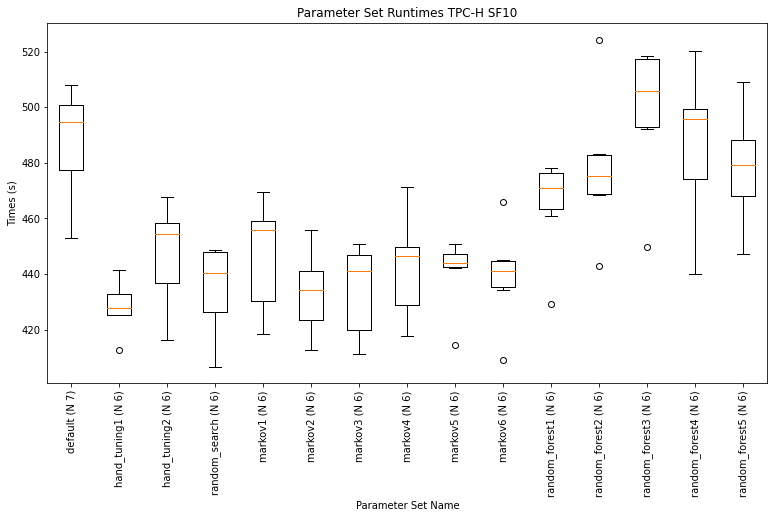

('6m', 'false', '260', '3', '4g', '7', '5', '7g', 'snappy', '0.7', '0.6', 'false', '80m', '256', 'true', '32k', 'false', '80', '1') !!!
('6m', 'true', '180', '4', '4g', '1', '2', '4g', 'snappy', '0.4', '0.4', 'true', '80m', '256', 'false', '112k', 'false', '70', '1') !!!
('12m', 'false', '380', '1', '4g', '4', '6', '4g', 'snappy', '0.7', '0.7', 'false', '72m', '224', 'false', '80k', 'false', '90', '1') !!!
('4m', 'false', '140', '1', '4g', '5', '6', '3g', 'lz4', '0.6', '0.6', 'false', '80m', '160', 'false', '64k', 'false', '120', '1') !!!
('18m', 'false', '260', '4', '4g', '4', '5', '3g', 'snappy', '0.8', '0.7', 'true', '96m', '192', 'false', '48k', 'true', '80', '1') !!!
('6m', 'false', '260', '3', '4g', '7', '5', '7g', 'snappy', '0.7', '0.6', 'false', '80m', '256', 'true', '32k', 'false', '80', '1') !!!
('6m', 'true', '180', '4', '4g', '1', '2', '4g', 'snappy', '0.4', '0.4', 'true', '80m', '256', 'false', '112k', 'false', '70', '1') !!!
('12m', 'false', '380', '1', '4g', '4', '6', '4

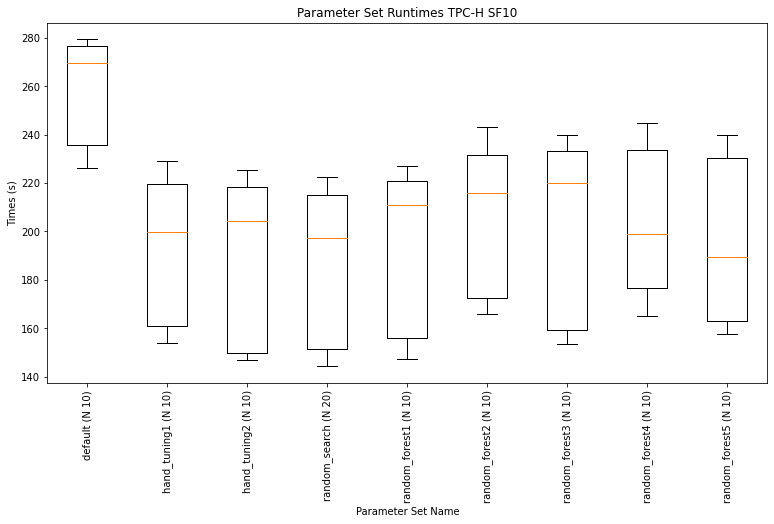

In [162]:
# comparing results of chosen parameter sets 

direc = './training_results'
training_fnames = [f'{direc}/{x}'for x in os.listdir(direc) if 'txt' in x and 'compare_all' in x]
#direc = '../../../../nobackup1/hoped/spark-autotuner/training_data/training_results'

param_vals = [tuple(str(v) for _,v in sorted(pl.items())) for pl in raw_param_lists]
param_names = {param_vals[0]: 'default', param_vals[1]: 'hand_tuning1', param_vals[2]: 'hand_tuning2', param_vals[3]: 'random_search',}
param_names.update({param_vals[i+4]: f"markov{i+1}" for i in range(6)})
param_names.update({param_vals[-5:][i]: f"random_forest{i+1}" for i in range(5)})
print(len(param_vals))
print(len(param_names), param_names.values())

len(training_fnames)
print(training_fnames)
for FNAME in  training_fnames:
    import json
    import os
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    
    with open(FNAME,'r') as file:
        try:
            file_data = file.readlines()
        except Exception as e:
            print(FNAME, "load error")
            print(e)
            continue
    if len(file_data) < 5:
        continue

    class Parameter:
        def __init__(self, name):
            self.name = name
            self.val_to_results = []

        def add(self, results):
            self.val_to_results.append(results)

    param_name_to_param_obj = {}

    def populate_params():
        #analyze one file

        with open(FNAME, "r") as file:
            for line in file:
                d = eval(line)
       
                params = [(p['name'], p['cur_value']) for p in d["params"] if p['spark_param']]
                vals = tuple(str(v) for _,v in sorted(params))
                if vals not in param_names:
                    print(vals, "!!!")
                    continue
                name = param_names[vals]
                runtimes = d["runtimes"]
                if len(runtimes) == 0:
                    print("no times?")
                    continue

                if name not in param_name_to_param_obj:
                    param_name_to_param_obj[name] = Parameter(name)
                obj = param_name_to_param_obj[name]
                assert "total" in runtimes
                obj.add(runtimes)

    def analyze_results():
        populate_params()
        timess = []
        names = []
 
        for p in param_name_to_param_obj:
            min_runtime = float("inf")
            max_runtime = -float("inf")
            times = []
            obj = param_name_to_param_obj[p]
            for d in obj.val_to_results:
                total_time = d['total']
                times.append(total_time)
  
            timess.append(times)
            names.append(f'{p} (N {len(times)})')
            #names.append(p)

      
        name = FNAME.split('/')[-1].split('.')[0]
        print(name)
        data = timess
        fig = plt.figure(figsize =(10, 5))

        # Creating axes instance
        ax = fig.add_axes([0, 0, 1, 1])

        # Creating plot
        bp = ax.boxplot(data)

        ax.set_xticklabels(names)
        plt.xticks(rotation=90)
        plt.title(f"Parameter Set Runtimes")
        plt.xlabel("Parameter Set Name")
        plt.ylabel("Times (s)")
        plt.savefig(f"./training_sensitivity/compare_boxplots{name}.jpg", bbox_inches="tight")
        plt.title(f"Parameter Set Runtimes TPC-H SF10")
        plt.show()

    analyze_results()
    
# run it locally
# check number of rows that are loading
# look at and verify result to materialize the answer

In [163]:
# How many tuned parameter sets are found in train data?
# How many params outperformed default?
def tuplify_vals(pdl):
    return tuple(str(v) for _,v in sorted([(x['name'], x['cur_value']) for x in pdl if x['spark_param']]) )
with open(f"{direc}/sf10_training_data.json", "r") as outfile:
    result = json.load(outfile)
f = open(f"{direc}/sf10_training_data.txt", "r")
result_txt = f.readlines()
result_txt = [eval(x) for x in result_txt]
f.close()

raw_result = {}
for d in result.values():
    k = tuplify_vals(d['params'])
    raw_result.setdefault(k, [])
    if d['runtimes']:
        raw_result[k].append(d['runtimes']['total'])

def_tup = tuple(str(v) for _,v in sorted(deft.items()))

raw_resulttxt = {}
for d in result_txt:
    k = tuplify_vals(d['params'])
    raw_resulttxt.setdefault(k, [])
    if d['runtimes']:
        raw_resulttxt[k].append(d['runtimes']['total'])
    

print("Num unique params:", len(raw_result), len(raw_resulttxt))
print("How many tuned parameter sets are found in train data?")
select_repeats = [param_names[k] for k in param_names if k in raw_result]
select_repeatstxt = [param_names[k] for k in param_names if k in raw_resulttxt]
print(len(select_repeats), select_repeats)
print(len(select_repeatstxt), select_repeatstxt)
    


Num unique params: 3145 2882
How many tuned parameter sets are found in train data?
2 ['default', 'random_search']
2 ['default', 'random_search']


How many params outperformed the default? 1102 1076
[1]
[111.53646945953369, 152.56019234657288, 192.52007675170898, 258.17023038864136, 412.6187799930571, 1206.5933125019073]


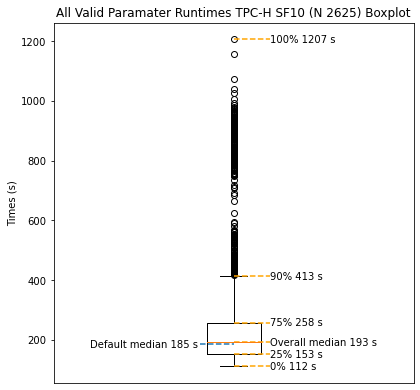

In [164]:
# How many params outperformed the default?
c = 0
all_times = []
def_med = min(raw_result[def_tup])
for times in raw_result.values():
    
    if times and np.median(times) < def_med:
        c += 1

ct = 0
def_med = np.median(raw_resulttxt[def_tup])
for times in raw_resulttxt.values():
    all_times.extend(times)
    if times and np.median(times) < def_med:
        ct += 1
print("How many params outperformed the default?", c, ct)

data = [all_times]
fig = plt.figure(figsize =(5, 5))

# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])

# Creating plot
bp = ax.boxplot(data)
print(ax.get_xticks())
percentiles = [np.percentile(all_times, i) for i in [0,25,50,75,90,100]]
nms = ['0%', '25%', 'Overall median', '75%', '90%', '100%']
print(percentiles)
for i in range(len(nms)):
    plt.plot((1., 1.1), (percentiles[i], percentiles[i]) , linestyle='--', color='orange')
    plt.annotate(f'{nms[i]} {round(percentiles[i])} s', (1.1, percentiles[i]-10))
    
#ax.set_xticklabels(names)
plt.plot((.905, 1.), (def_med, def_med) , linestyle='--')
plt.annotate(f'Default median {round(def_med)} s', (.6, def_med-10))
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
#plt.xlabel("Parameter Set Name")
plt.ylabel("Times (s)")
plt.title(f"All Valid Paramater Runtimes TPC-H SF10 (N {len(all_times)}) Boxplot")
plt.savefig(f"./training_sensitivity/all_runtimes.jpg", bbox_inches="tight")
plt.show()


['./training_results/sf10_n10_det_main0.txt', './training_results/sf10_n10_det_main_fix.txt', 'all_det']
{'spark.broadcast.blockSize': '4m', 'spark.broadcast.compress': 'true', 'spark.default.parallelism': '200', 'spark.driver.cores': '1', 'spark.driver.memory': '1g', 'spark.executor.cores': '1', 'spark.executor.instances': '2', 'spark.executor.memory': '1g', 'spark.io.compression.codec': 'lz4', 'spark.memory.fraction': '0.6', 'spark.memory.storageFraction': '0.5', 'spark.rdd.compress': 'false', 'spark.reducer.maxSizeInFlight': '48m', 'spark.rpc.message.maxSize': '128', 'spark.shuffle.compress': 'true', 'spark.shuffle.file.buffer': '32k', 'spark.shuffle.spill.compress': 'true', 'spark.sql.shuffle.partitions': '100', 'spark.task.cpus': '1'}
sf10_n10_det_main0


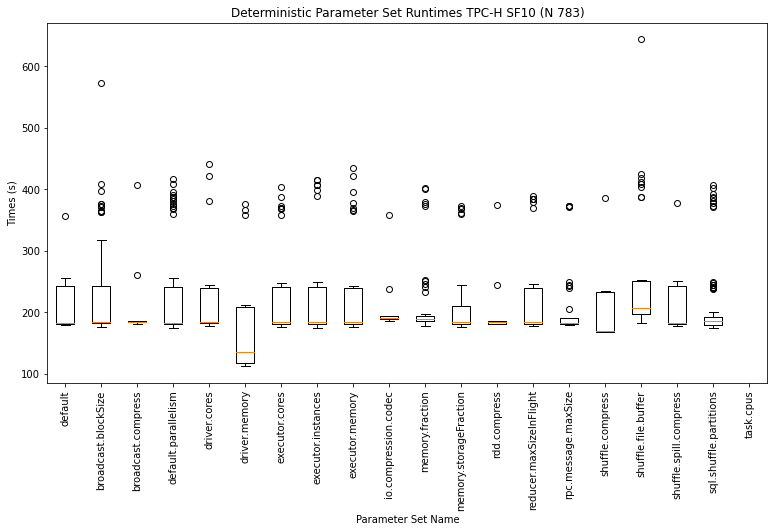

['', '0.6', '0.5', 'false', '48m', '128', 'true', '32k', 'true']
['', '(0.3, 0.8)', '(0.3, 0.8)', '(true, false)', '(48m, 96m)', '(128, 256)', '(true, false)', '(32k, 128k)', '(true, false)']
10 10
!!!!!!!!!!!!!!
10 10 10
['', '(4m, 24m)', '(true, false)', '(20, 380)', '(1, 4)', '(1g, 4g)', '(1, 8)', '(2, 8)', '(1g, 8g)', '(lz4, snappy)', '(0.3, 0.8)']
['', '(0.3, 0.8)', '(0.3, 0.8)', '(true, false)', '(48m, 96m)', '(128, 256)', '(true, false)', '(32k, 128k)', '(true, false)', '(50, 140)']
[0, 2.5, 5.5, 8.5, 11.5, 14.5, 17.5, 20.5, 23.5, 26.5]
10 10 ['default', 'broadcast\nblockSize', 'broadcast\ncompress', 'default\nparallelism', 'driver\ncores', 'driver\nmemory', 'executor\ncores', 'executor\ninstances', 'executor\nmemory', 'io\ncompression\ncodec']


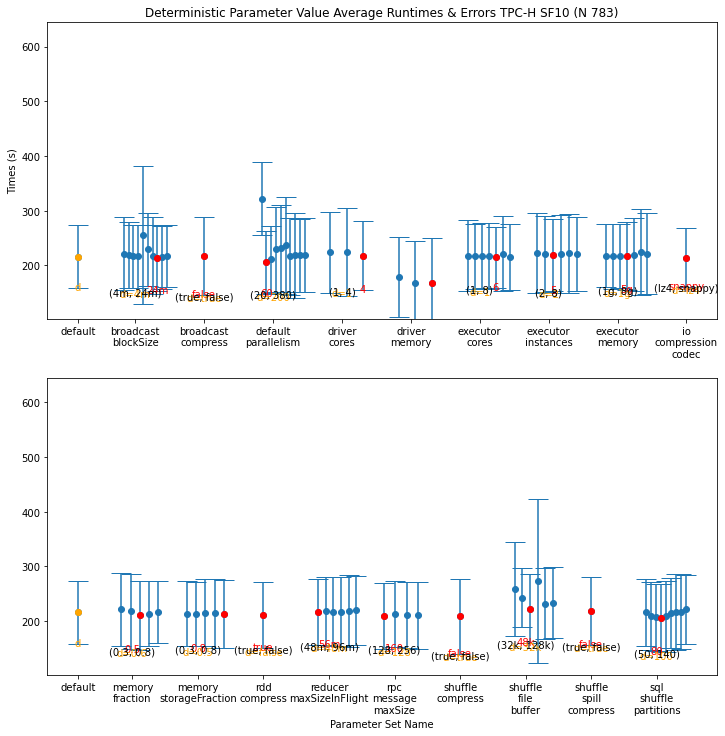

sf10_n10_det_main_fix


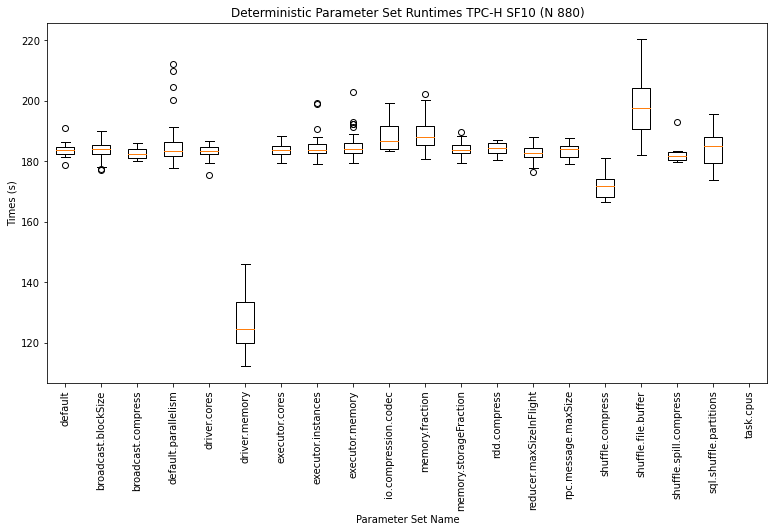

['', '0.6', '0.5', 'false', '48m', '128', 'true', '32k', 'true']
['', '(0.3, 0.8)', '(0.3, 0.8)', '(true, false)', '(48m, 96m)', '(128, 256)', '(true, false)', '(32k, 128k)', '(true, false)']
10 10
!!!!!!!!!!!!!!
10 10 10
['', '(4m, 24m)', '(true, false)', '(20, 380)', '(1, 4)', '(1g, 4g)', '(1, 8)', '(2, 8)', '(1g, 8g)', '(lz4, snappy)', '(0.3, 0.8)']
['', '(0.3, 0.8)', '(0.3, 0.8)', '(true, false)', '(48m, 96m)', '(128, 256)', '(true, false)', '(32k, 128k)', '(true, false)', '(50, 140)']
[0, 2.5, 5.5, 8.5, 11.5, 14.5, 17.5, 20.5, 23.5, 26.5]
10 10 ['default', 'broadcast\nblockSize', 'broadcast\ncompress', 'default\nparallelism', 'driver\ncores', 'driver\nmemory', 'executor\ncores', 'executor\ninstances', 'executor\nmemory', 'io\ncompression\ncodec']


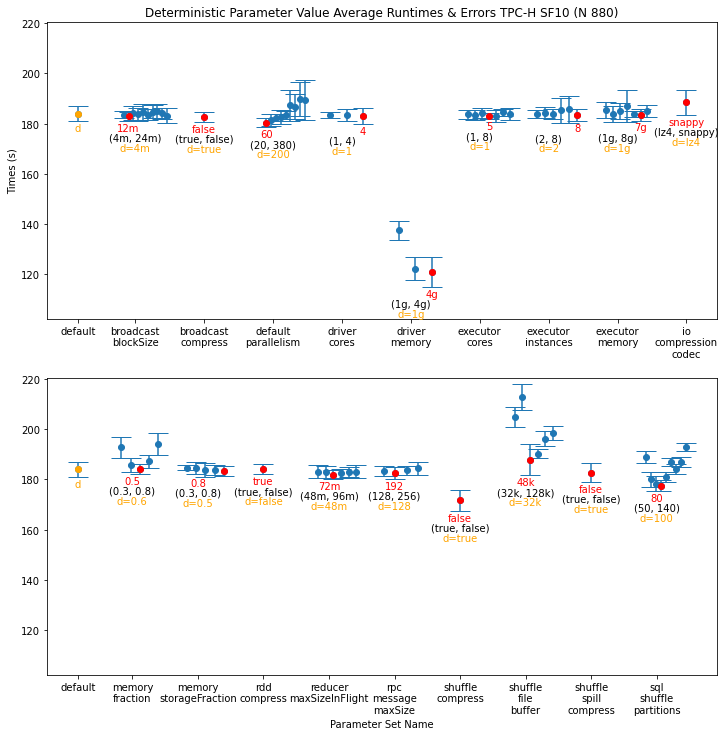

all_det load error
[Errno 2] No such file or directory: 'all_det'
all_det


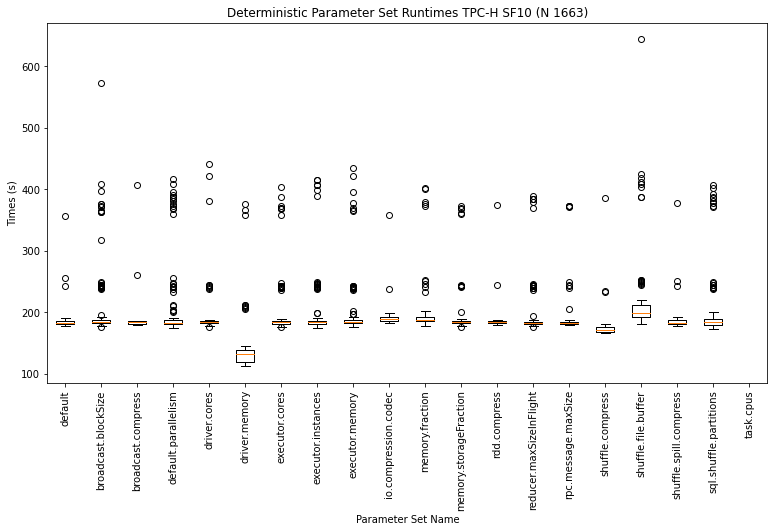

['', '0.6', '0.5', 'false', '48m', '128', 'true', '32k', 'true']
['', '(0.3, 0.8)', '(0.3, 0.8)', '(true, false)', '(48m, 96m)', '(128, 256)', '(true, false)', '(32k, 128k)', '(true, false)']
10 10
!!!!!!!!!!!!!!
10 10 10
['', '(4m, 24m)', '(true, false)', '(20, 380)', '(1, 4)', '(1g, 4g)', '(1, 8)', '(2, 8)', '(1g, 8g)', '(lz4, snappy)', '(0.3, 0.8)']
['', '(0.3, 0.8)', '(0.3, 0.8)', '(true, false)', '(48m, 96m)', '(128, 256)', '(true, false)', '(32k, 128k)', '(true, false)', '(50, 140)']
[0, 2.5, 5.5, 8.5, 11.5, 14.5, 17.5, 20.5, 23.5, 26.5]
10 10 ['default', 'broadcast\nblockSize', 'broadcast\ncompress', 'default\nparallelism', 'driver\ncores', 'driver\nmemory', 'executor\ncores', 'executor\ninstances', 'executor\nmemory', 'io\ncompression\ncodec']


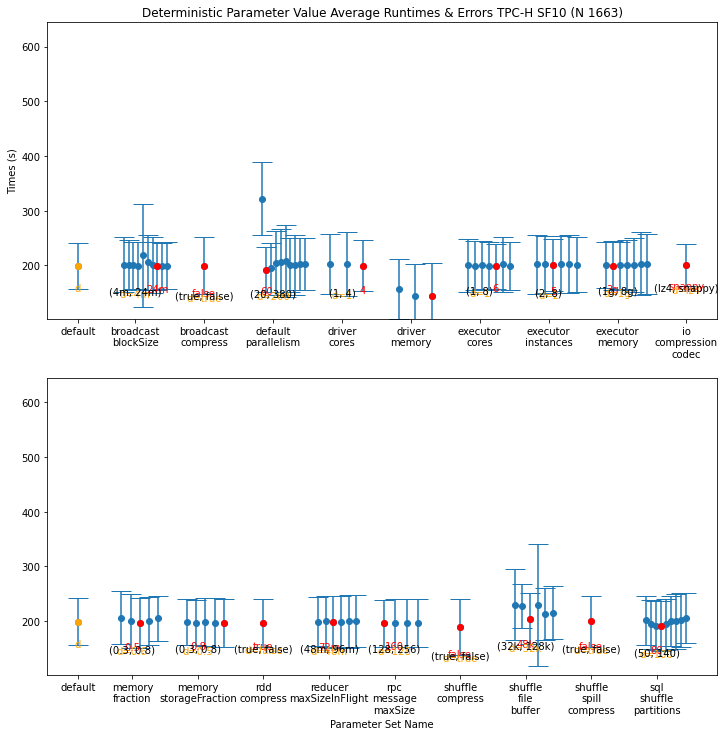

In [166]:
direc = './training_results'
training_fnames = [f'{direc}/{x}'for x in os.listdir(direc) if 'txt' in x and 'sf10' in x and 'det' in x]
#direc = '../../../../nobackup1/hoped/spark-autotuner/training_data/training_results'
training_fnames += ['all_det']
all_file_data = []
len(training_fnames)
print(training_fnames)
print(deft)
for FNAME in  training_fnames:
    import json
    import os
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    
    try:
        with open(FNAME,'r') as file:
            file_data = file.readlines()
            all_file_data += file_data
    except Exception as e:
        file_data = all_file_data
        print(FNAME, "load error")
        print(e)
    all_tz = []

    class Parameter:
        def __init__(self, name):
            self.name = name
            self.val_to_results = {'default':[]}
            ff = eval(all_file_data[-1])
            for p in ff['params']:
                if p['name'] == name:
                    self.val_to_results = {x:[] for x in p['possible_values'] if str(x) != str(p['default_value'])}

        def add(self, param_val, results):
            if results:
                 self.val_to_results[param_val].append(results['total'])

        def get_totals(self, param_val):
            return self.val_to_results[param_val]

        def get_param_vals(self):
            return self.val_to_results.keys()

    param_name_to_param_obj = {}

    def populate_params():
        #analyze one file
        for line in file_data:
            d = eval(line)

            params = [p for p in d["params"] if p['spark_param']]
            runtimes = d["runtimes"]
            if runtimes:
                all_tz.append(runtimes['total'])
            all_default = True
            for p in params:
                if str(p['cur_value']) != str(p['default_value']):
                    varying_param = p['name']
                    all_default = False
                    break
            if all_default:
                if 'default' not in param_name_to_param_obj:
                    param_name_to_param_obj["default"] = Parameter('default')

                obj = param_name_to_param_obj["default"]
                obj.add("default", runtimes)
                continue

            if varying_param not in param_name_to_param_obj:
                param_name_to_param_obj[varying_param] = Parameter(varying_param)
            obj = param_name_to_param_obj[varying_param]
            obj.add(p['cur_value'], runtimes)

    def analyze_results():
        populate_params()
        pnum = {}
        default = param_name_to_param_obj["default"]
        default_total = default.get_totals("default")
        names = ['default']
        nms = ['default']
        data = [default_total]
        med_data = []
        med_names = []
        count = len(file_data)
        for p in sorted(param_name_to_param_obj):
            if p == 'default':
                 continue

            
            obj = param_name_to_param_obj[p]
            pnum[p] = len(obj.val_to_results)
            all_times = []
            for k in obj.get_param_vals():
                all_times.extend(obj.get_totals(k))
            nms.append(f'{p.split("spark.")[1]}')
            names.append(f'{p}')
            data.append(all_times)
            for k in sorted(obj.get_param_vals()):
                med_names.append(f'{p}_{k}')
                med_data.append(obj.get_totals(k))
                

        name = FNAME.split('/')[-1].split('.')[0]
        print(name)
        fig = plt.figure(figsize =(10, 5))

        # Creating axes instance
        ax = fig.add_axes([0, 0, 1, 1])

        # Creating plot
        bp = ax.boxplot(data)

        ax.set_xticklabels([f'{n}' for i,n in enumerate(nms)])
        plt.xticks(rotation=90)
        plt.title(f"Deterministic Parameter Set Runtimes TPC-H SF10 (N {count})")
        plt.xlabel("Parameter Set Name")
        plt.ylabel("Times (s)")
        plt.savefig(f"./training_sensitivity/det_boxplots{name}.jpg", bbox_inches="tight")
       
        plt.show()
        
        
        figure, axis = plt.subplots(2, 1, figsize=(12, 12))


        # Creating errorbars 
        x1 = [0]
        y1 = [np.average(default_total)]
        e1 = [np.std(default_total)]
        x2, y2, e2 = [0], [np.average(default_total)], [np.std(default_total)]
        prev_p = 'default'
        nm_rng = {}
        ff = eval(all_file_data[-1])
        for p in ff['params']:
            if p['spark_param']:
                nm_rng[p['name']] = f"({p['possible_values'][0]}, {p['possible_values'][-1]})"
            
        n = 0
        t1 = set([0])
        t2 = set([0])
        besta1 = [np.average(default_total)]
        bestx1 = [x1[-1]]
        bestk1 = ['d']
        besta2 = [np.average(default_total)]
        bestk2 = ['d']
        bestx2 = [x2[-1]]
        my1 = [y1[0]-e1[0]]
        my2 = [y2[0]-e2[0]]
        rng1 = ['']
        def1 = ['']
        def2 = ['']
        prev_k=''
        rng2 = ['']
        for i in range(len(med_names)-1):
            p, k = med_names[i].split("_")
            if prev_p!=p:
                if (names.index(prev_p) < (len(names)-1)/2):
                    def1.append(deft[p])
                    rng1.append(nm_rng[p])
                else:
                    def2.append(deft[prev_p])
                    rng2.append(nm_rng[prev_p])
                n = 0
                prev_p = p
            else:
                n += 2.1/(pnum[p])
            prev_k=k
            yv = 0 if not med_data[i] else np.average(med_data[i])
            ev = 0 if not med_data[i] else np.std(med_data[i])
            xv = 3*names.index(p) + n -1
            if pnum[p] == 1:
                    xv += .5
            if (names.index(p) < (len(names)-1)/2):
                x1.append(xv)
                y1.append(yv)
                e1.append(ev)
                t1.add(3*names.index(p)-.5)
                if n == 0:
                    besta1.append(float('inf') if not med_data[i] else np.average(med_data[i]))
                    bestk1.append(k)
                    bestx1.append(x1[-1])
                    my1.append(y1[-1]-e1[-1])
                else:
                    bestk1[-1] = k if yv < besta1[-1] else bestk1[-1]
                    bestx1[-1] = xv if yv < besta1[-1] else bestx1[-1]
                    my1[-1] = (y1[-1]-e1[-1]) if yv < besta1[-1] else my1[-1]
                    besta1[-1] = yv if yv < besta1[-1] else besta1[-1]
                    
            else:
                xv -= 3*(len(names)-1)//2-1
                x2.append(xv)
                y2.append(yv)
                e2.append(ev)
                t2.add(3*names.index(p)-1)
                if n == 0:
                    besta2.append(float('inf') if not med_data[i] else np.average(med_data[i]))
                    bestk2.append(k)
                    bestx2.append(x2[-1])
                    my2.append(y2[-1]-e2[-1])
                else:
                    bestk2[-1] = k if yv < besta2[-1] else bestk2[-1]
                    bestx2[-1] = xv if yv < besta2[-1] else bestx2[-1]
                    my2[-1] = (y2[-1]-e2[-1]) if yv < besta2[-1] else my2[-1]
                    besta2[-1] = yv if yv < besta2[-1] else besta2[-1]
        # for task cpus
        #besta2.append(10)
        #my2.append(0)
        #bestx2.append(29.5)
        #bestk2.append("1")
        #rng2 = rng2[:2] + rng2[3:]
        print(def2)
        print(rng2)
        #rng2.append(nm_rng['spark.task.cpus'])
        xs1 = list(sorted(t1))
        rng2.append(nm_rng[p])
        #xs1.append(xs1[-1]+3)
        print(len(t1), len(t2))
        
        #rng1[1] = '(4m, 24m)'
        print("!!!!!!!!!!!!!!")
        print(len(bestk2), len(xs1), len(my2))
        print(rng1)
        print(rng2)

        
        print(xs1)
        #rng2[-1] = f'({rng2[-1]}, {k})' if rng2[-1] else ''
        def2.append(deft[p])
        axis[1].scatter(bestx2[:1], besta2[:1], color='orange', zorder=10)
        axis[1].scatter(bestx2[1:], besta2[1:], color='red', zorder=10)
        axis[0].scatter(bestx1[:1], besta1[:1], color='orange', zorder=10)
        axis[0].scatter(bestx1[1:], besta1[1:], color='red', zorder=10)
        for i in range(len(besta2)):
            if i == 0:
                axis[1].annotate(f'{bestk2[i]}', (xs1[i], my2[i]-4), color='orange', ha='center')
            else:
                axis[1].annotate(f'{bestk2[i]}', (xs1[i], my2[i]-4), color='red', ha='center')
                axis[1].annotate(f'd={def2[i]}', (xs1[i], my2[i]-12), color='orange', ha='center')
            axis[1].annotate(f'{rng2[i]}', (xs1[i], my2[i]-8), color='black', ha='center')
            
        for i in range(len(besta1)):
            if i == 0:
                axis[0].annotate(f'{bestk1[i]}', (bestx1[i], my1[i]-4), color='orange', ha='center')
            else:
                axis[0].annotate(f'{bestk1[i]}', (bestx1[i], my1[i]-4), color='red', ha='center')
                axis[0].annotate(f'd={def1[i]}', (xs1[i], my1[i]-12), color='orange', ha='center')
            axis[0].annotate(f'{rng1[i]}', (xs1[i], my1[i]-8), color='black', ha='center')
           
        
        axis[0].errorbar(x1, y1, e1, fmt='o', capsize=10)
        axis[1].errorbar(x2, y2, e2, fmt='o', capsize=10)
        axis[0].set_ylim([min(all_tz)-10, max(all_tz)])
        axis[1].set_ylim([min(all_tz)-10, max(all_tz)])
        #plt.annotate(f'Default median {round(def_med)} s', (-1, def_med+10))
  

        axis[0].set_xticks(xs1)
        l1= [nms[0]]+[nms[i+1] for i in range(len(t1)-1)]
        l1 = ["\n".join(n.split(".")) for n in l1]
        print(len(xs1), len(l1), l1 )
        axis[0].set_xticklabels(l1, rotation=0, zorder=10)
        axis[1].set_xticks(xs1)
        l2= [nms[0]]+[nms[i+len(t1)] for i in range(len(t2)-1)]
        l2 = ["\n".join(n.split(".")) for n in l2]
        axis[1].set_xticklabels(l2, rotation=0, zorder=10)
        axis[0].set_title(f"Deterministic Parameter Value Average Runtimes & Errors TPC-H SF10 (N {count})")
        axis[1].set_xlabel("Parameter Set Name")
        axis[0].set_ylabel("Times (s)")
        #plt.savefig(f"./training_sensitivity/det_errors_{name}.jpg", bbox_inches="tight")
       
        plt.show()

    analyze_results()
    
